# Noise Models in qLDPC

This notebook demonstrates how to use noise models in the qLDPC library. Noise models are essential for simulating realistic quantum error correction scenarios by adding errors to quantum circuits.

We'll cover:
- Creating basic noise models with uniform depolarizing errors
- Applying noise to circuits with and without idling errors
- Working with quantum error correction codes
- Generating memory experiments with syndrome measurements

Let's start by exploring the basic functionality of noise models.

## Basic Circuit Creation

First, let's create a simple quantum circuit using Stim. This example shows how to build a basic circuit with a Hadamard gate followed by CNOT gates to create entanglement.

Original Circuit:


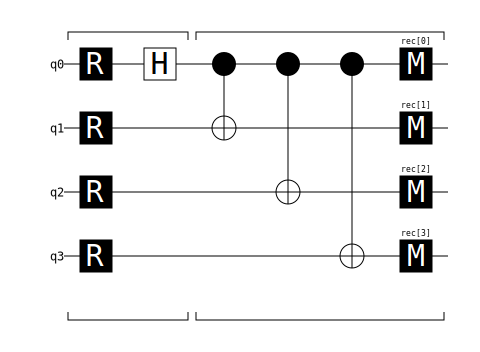

In [67]:
import stim
from qldpc.stim.noise_model import NoiseModel

# Create a stim circuit
circuit = stim.Circuit()
circuit.append("RZ", [0,1,2,3])  # Example gate
# Add your gates, measurements, etc.
circuit.append("H", [0])
circuit.append("TICK")
for i in range(1, 4):
    circuit.append("CNOT", [0, i])
# Add a measurement
circuit.append("M", [0, 1, 2, 3])

print("Original Circuit:")
circuit.diagram("timeline-svg")

## Applying Noise Models

Now we'll apply a uniform depolarizing noise model to our circuit. Depolarizing noise is a common quantum error model where each qubit operation has a probability `p` of being followed by a random Pauli error (X, Y, or Z). Measurement and reset operations are followed by "readout errors" and Pauli X errors respectively.

The `idling_error=False` parameter means we don't add errors during idle times when qubits are not being actively operated on.


Noisy Circuit (no idling):


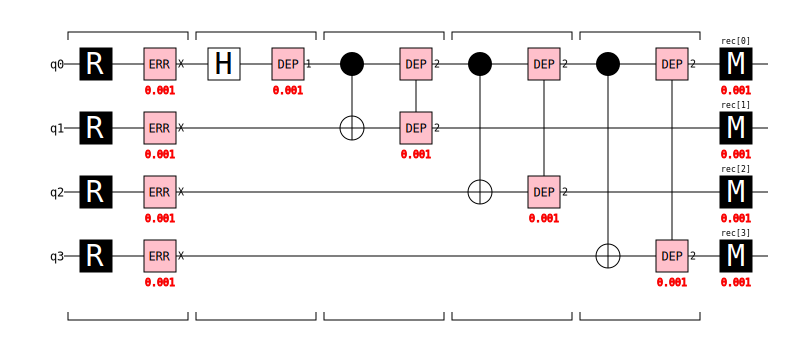

In [69]:
# Choose a noise model
p = 0.001  # Error probability parameter
noise_model = NoiseModel.uniform_depolarizing(p, idling_error=False)

# Apply noise to your circuit
noisy_circuit = noise_model.noisy_circuit(circuit)

print("\nNoisy Circuit (no idling):")
noisy_circuit.diagram("timeline-svg")

## Including Idling Errors

In realistic quantum systems, qubits can experience errors even when they're not being actively operated on (during "idle" time). Setting `idling_error=True` includes these errors in our noise model, making the simulation more realistic but also more complex.


Noisy Circuit (with idling):


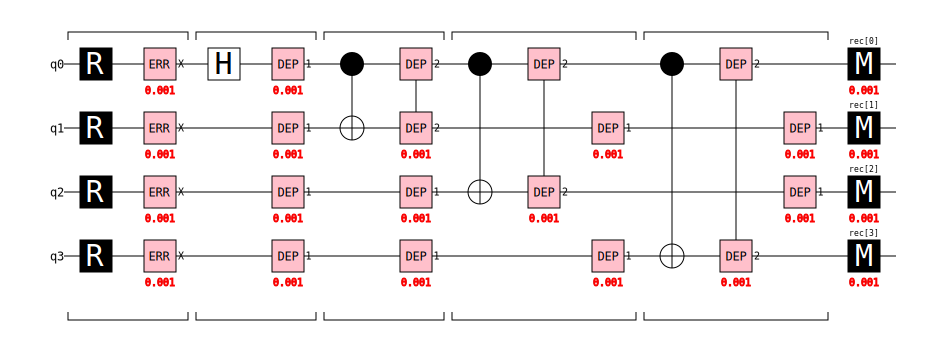

In [70]:
# If you want to include idling errors, you can set idling_error=True
noise_model_with_idling = NoiseModel.uniform_depolarizing(p, idling_error=True)
# Apply noise with idling errors
noisy_circuit_with_idling = noise_model_with_idling.noisy_circuit(circuit)
print("\nNoisy Circuit (with idling):")
noisy_circuit_with_idling.diagram("timeline-svg")

Custom noise models can also be defined with more control over different operations. See documentation of NoiseModel for more details.
In the example below we set different 1 qubit, 2 qubit, idling and measure/reset errors.


Noisy Circuit (custom noise model):


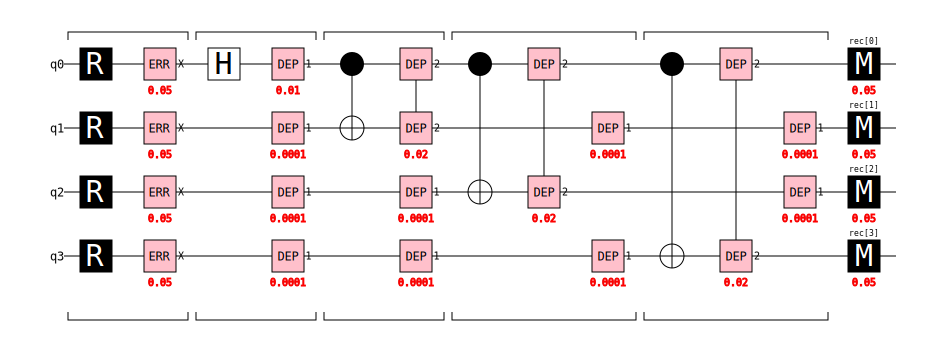

In [71]:
p_idle = 0.0001  # Idle error probability parameter
p_flip = 0.05  # Measurement flip error probability parameter
p_1q = 0.01  # 1-qubit gate error probability parameter
p_2q = 0.02  # 2-qubit gate error probability parameter


noise_model_with_idling = NoiseModel.custom(
        idle_depolarization= p_idle,
        clifford_1q_depolarization= p_1q,
        clifford_2q_depolarization= p_2q,
        measure_flip_x= p_flip,
        measure_flip_y= p_flip,
        measure_flip_z= p_flip,
        reset_x= p_flip,
        reset_y= p_flip,
        reset_z= p_flip,
)

# Apply the custom noise model to the circuit
noisy_circuit_custom = noise_model_with_idling.noisy_circuit(circuit)
print("\nNoisy Circuit (custom noise model):")
noisy_circuit_custom.diagram("timeline-svg")

## Parallel Operations and Automatic TICK Management

This example demonstrates how the noise model handles parallel two-qubit gates. When qubits are reused in subsequent operations, TICK instructions are automatically added to properly sequence the operations and apply noise at appropriate intervals.


Noisy Circuit (no idling, new circuit):


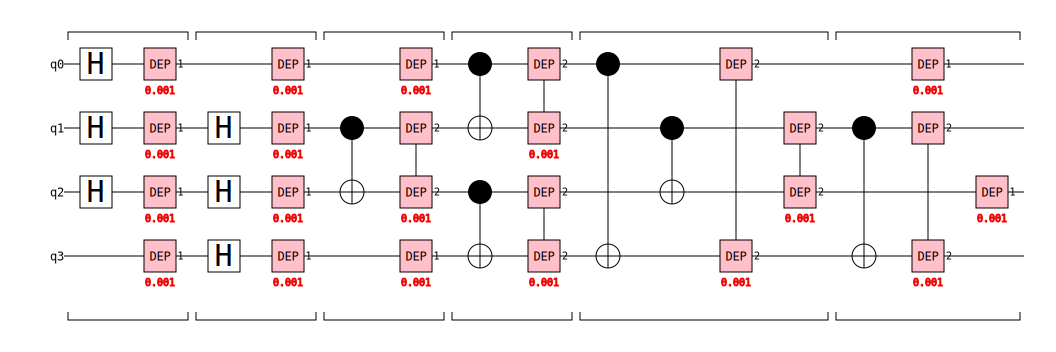

In [73]:
# example with parallel two qubit gates, TICKS will automatically be added before each qubit is reused

circuit = stim.Circuit()
# Add your gates, measurements, etc.
circuit.append("H", [0, 1, 2])
circuit.append("H", [1, 2, 3])
circuit.append("CNOT", [1, 2, 0, 1, 2, 3, 0, 3, 1, 2, 1, 3])

nm = NoiseModel.uniform_depolarizing(p, idling_error=True)
# Apply noise to your circuit
noisy_circuit = nm.noisy_circuit(circuit)
print("\nNoisy Circuit (no idling, new circuit):")
noisy_circuit.diagram("timeline-svg")

We can also use TICKS to manually control the timing for idling errors

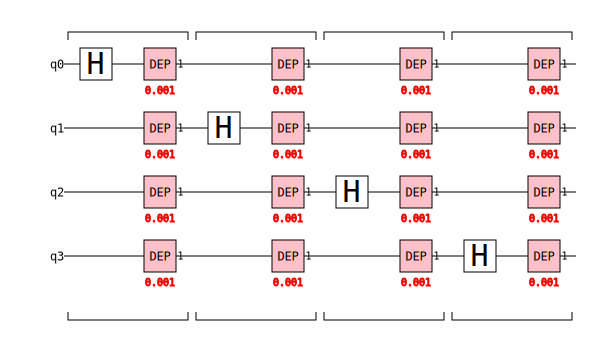

In [ ]:
circuit = stim.Circuit()
# Add your gates, measurements, etc.
for i in range(4):
    circuit.append("H", i)
    circuit.append("TICK")

# tell the noise model to not add TICKS automatically
nm.noisy_circuit(circuit, automatic_ticks=False).diagram("timeline-svg")

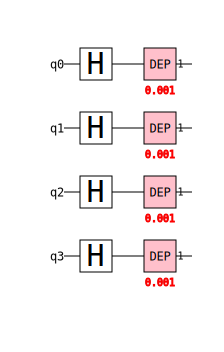

In [79]:
# compared to using automatic TICKS all H gates will be run in parallel
circuit = stim.Circuit()
# Add your gates, measurements, etc.
for i in range(4):
    circuit.append("H", i)

nm.noisy_circuit(circuit).diagram("timeline-svg")

## Working with Quantum Error Correction Codes

Now let's move to more sophisticated examples using actual quantum error correction codes. We'll use the Steane code, which is a 7-qubit CSS code that can correct single-qubit errors.

This example shows how to:
- Create a quantum error correction code
- Set up syndrome measurement circuits
- Apply noise models to error correction protocols

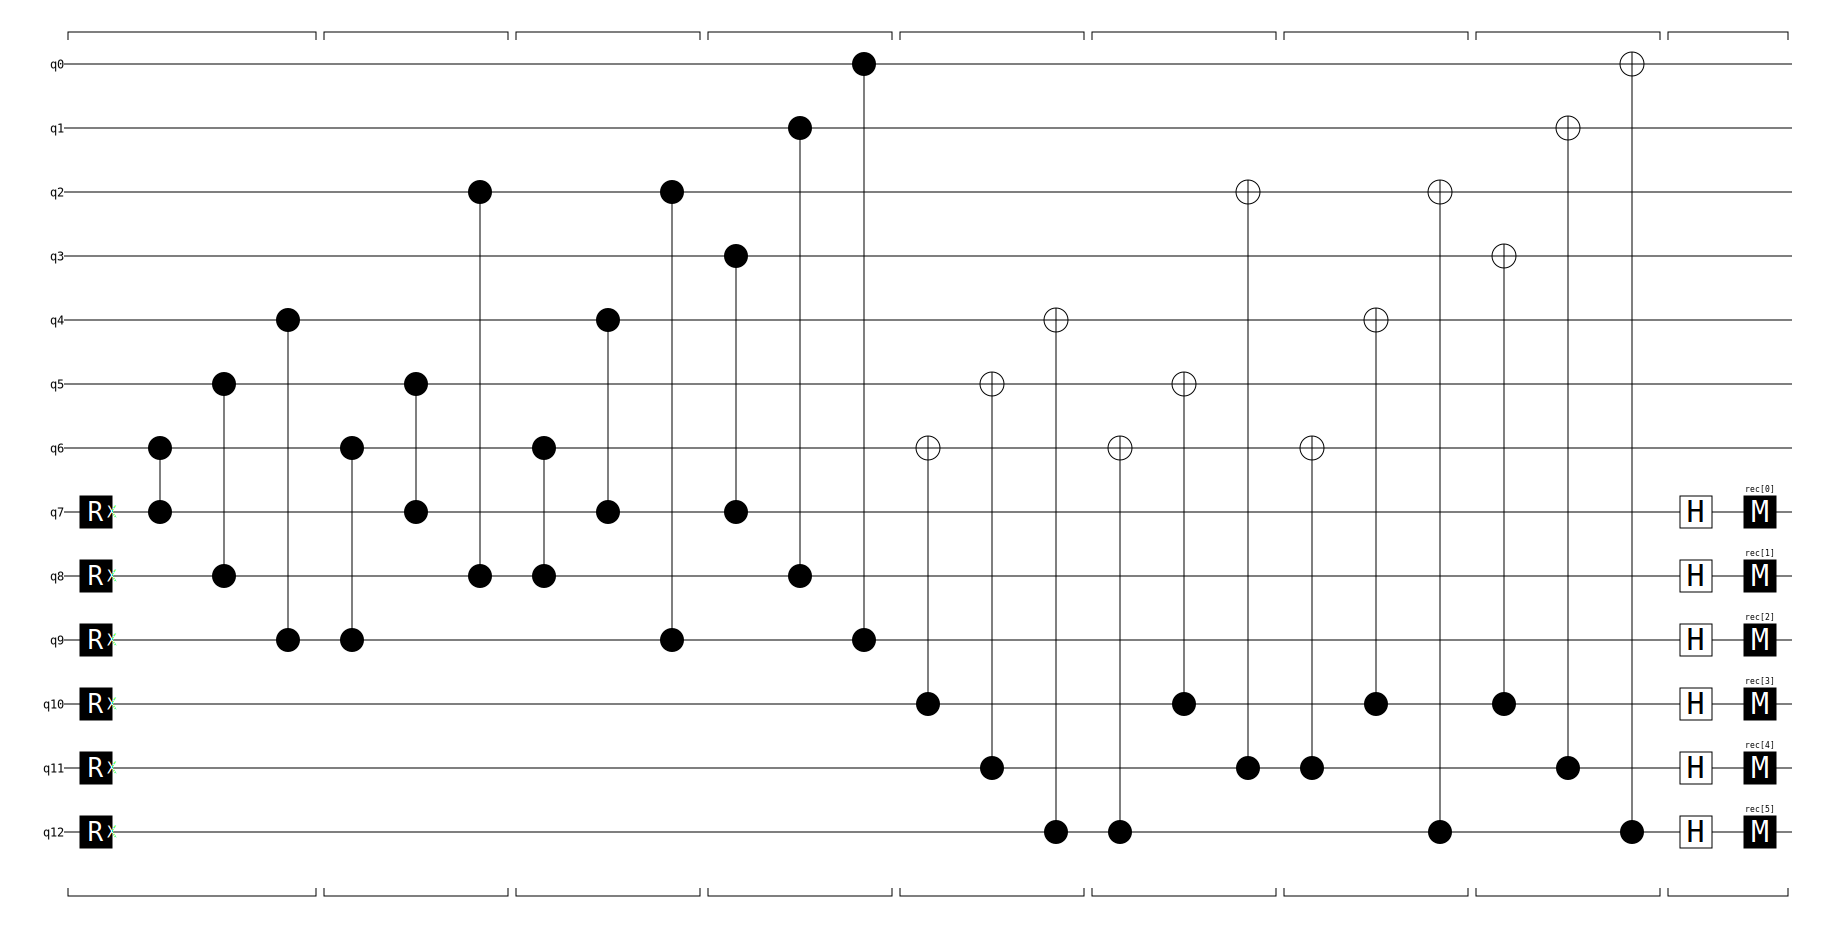

In [80]:
# start with a noiseless syndrome measurement circuit
from qldpc.codes import SteaneCode
from qldpc.stim.syndrome_measurement import BareColorCircuit, StimIds
from qldpc.stim.noise_model import NoiseModel

code = SteaneCode()

# Create noise model
noise_model = NoiseModel.uniform_depolarizing(0.001, idling_error=False)

# Create stim IDs
stim_ids = StimIds(
    data_ids=list(range(len(code))),
    z_check_ids=list(range(code.num_qubits, code.num_qubits + code.num_checks_z)),
    x_check_ids=list(range(code.num_qubits + code.num_checks_z, code.num_qubits + code.num_checks_z + code.num_checks_x)),
)

# Create BareColorCircuit and compile circuit
circuit_compiler = BareColorCircuit()
circuit, _ = circuit_compiler.compile_sm_circuit(code, stim_ids)

circuit.diagram("timeline-svg")


## Noisy Syndrome Measurement

Here we apply our noise model to the syndrome measurement circuit. This shows how errors affect not just the data qubits, but also the syndrome extraction process itself, which is crucial for realistic error correction simulations.

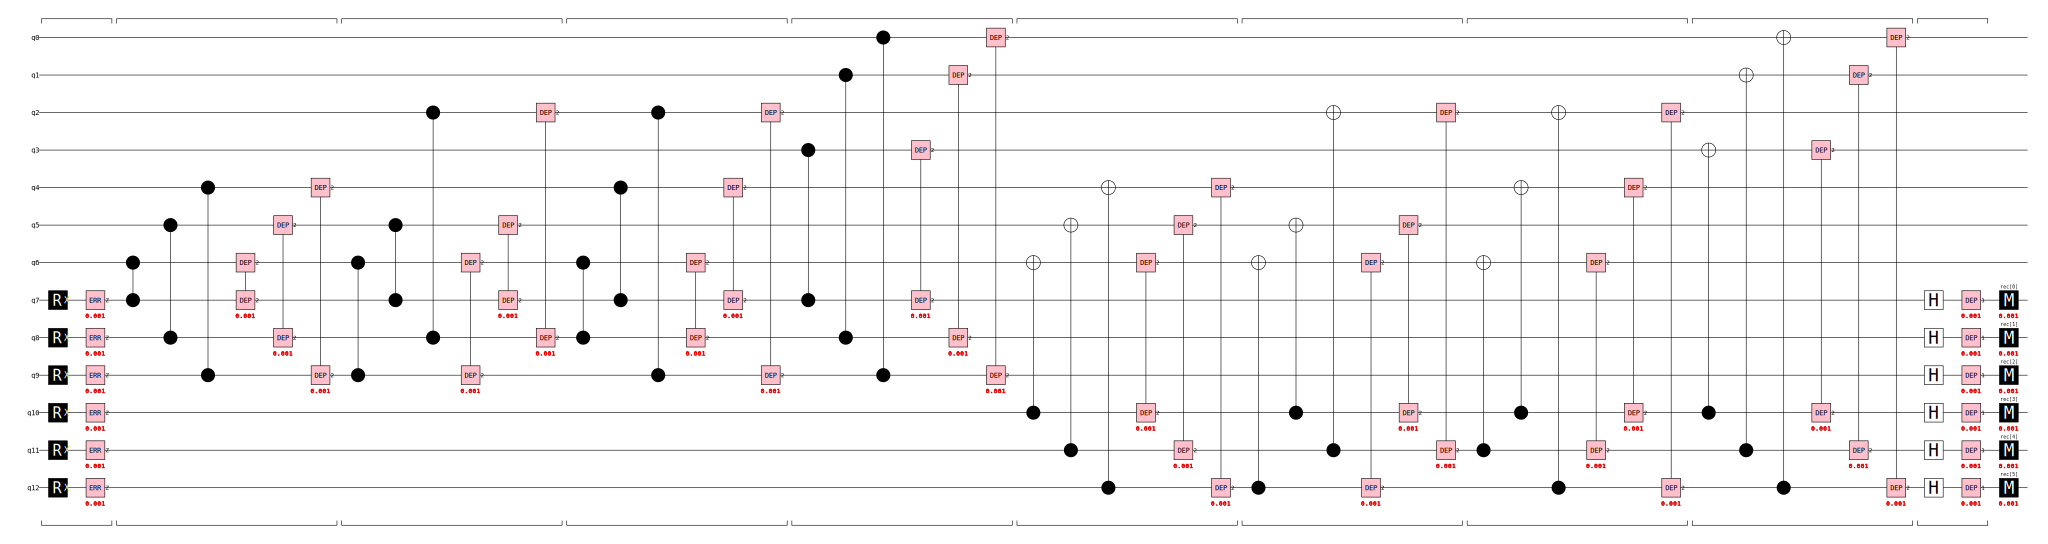

In [81]:
noise_model.noisy_circuit(circuit).diagram("timeline-svg")

## Memory Experiments with Surface Codes

Now we'll create a more comprehensive example using a Surface code, which is one of the most promising quantum error correction codes for practical implementation. We'll simulate a "memory experiment" where we:

1. Prepare a logical state
2. Perform multiple rounds of error correction
3. Measure the final logical state

This simulates how well the code preserves quantum information over time in the presence of noise.

Code Params: (9, 1, 3)


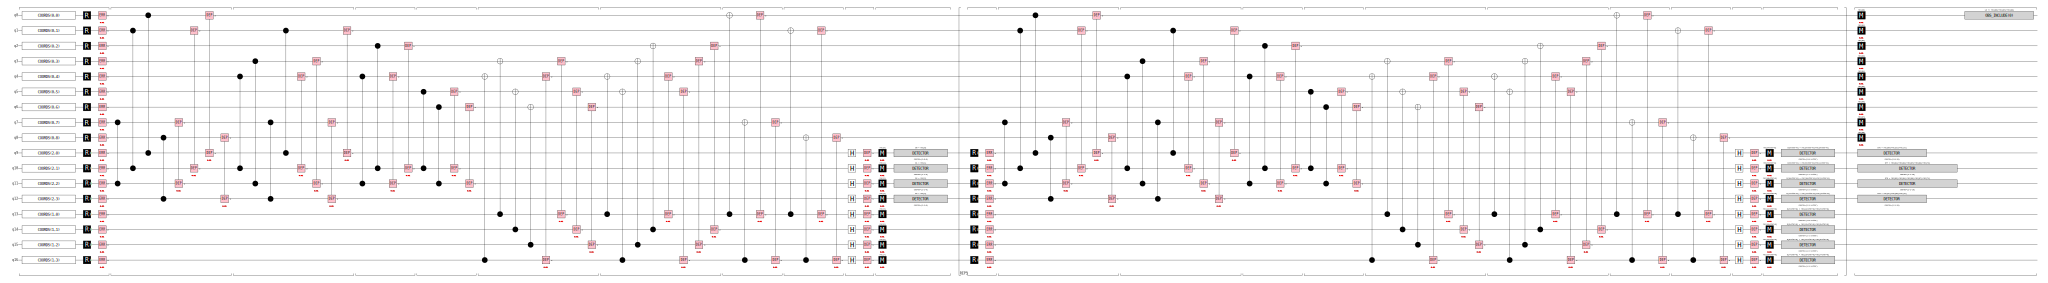

In [82]:
from qldpc.codes.quantum import SurfaceCode
from qldpc.stim.noise_model import NoiseModel
from qldpc.stim.syndrome_measurement import BareColorCircuit
from qldpc.objects import Pauli
from qldpc.stim.circuit import memory_experiment

# Create a 3-qubit repetition code
css_code = SurfaceCode(3, 3)
print(f"Code Params: {css_code.get_code_params(bound=False)}")
noise_model = NoiseModel.uniform_depolarizing(0.01, idling_error=False)
syndrome_meas = BareColorCircuit()
num_rounds=10
basis=Pauli.Z

# Generate 5-round Z-basis memory experiment
circuit = memory_experiment(
             code=css_code,
             noise_model=noise_model,
             syndrome_measurement_strategy=syndrome_meas,
             num_rounds=num_rounds,
             basis=basis
         )

circuit.diagram("timeline-svg")

## Sampling Syndrome Measurements

Now we'll sample actual syndrome measurements from our noisy memory experiment. Each row represents the syndrome measurements from one round of error correction, showing which stabilizer checks detected errors. The pattern of syndromes over time can be used to infer what errors occurred and how to correct them.

In [83]:
# sample syndrome measurements

n = css_code.num_checks
sampler = circuit.compile_sampler()
one_sample = sampler.sample(shots=1)[0]
to_bitmask = lambda timeslice: "".join("1" if e else "_" for e in timeslice)
for k in range(0, len(one_sample) - 1, n):
    timeslice = one_sample[k:k+n]
    print(to_bitmask(timeslice))

_____11_
__1__11_
_1___111
_1___111
_11__11_
_11__11_
_11__11_
_11__11_
_11__11_
_11__1__
__1___1_


## Detector Sampling

Finally, we use Stim's detector sampling feature, which is designed specifically for error correction analysis. Detectors identify when syndrome measurements change between rounds, which is often more useful for decoding algorithms than the raw syndrome measurements themselves.

In [84]:
detector_sampler = circuit.compile_detector_sampler()
one_sample = detector_sampler.sample(shots=1)[0]
for k in range(0, len(one_sample) - 1, n):
    timeslice = one_sample[k:k+n]
    print(to_bitmask(timeslice))

__1_____
__11____
____1___
________
1____1__
1____1__
________
________
________
________


For full quantum memory experiments with Sinter, see [circuit_simulations.ipynb](circuit_simulations.ipynb).